In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
DATA_FOLDER = "C:/Users/Sahu Suraj/Videos/New Project/DeepFake Detection/"
TRAIN_SAMPLE_FOLDER = "DATASET"
print(f"Train Samples: {len(os.listdir(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER)))}")

Train Samples: 12739


In [3]:
train_sample_metadata = pd.read_json("C:/Users/Sahu Suraj/Videos/New Project/DeepFake Detection/DATASET/metadata.json").T
train_sample_metadata.head()

,label,split,original
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
vpmyeepbep.mp4,REAL,train,NaN
fzvpbrzssi.mp4,REAL,train,NaN
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


In [4]:
# train_sample_metadata = train_sample_metadata.reset_index().rename(columns={'index': 'Video'})

In [5]:
train_sample_metadata.head()

,label,split,original
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
vpmyeepbep.mp4,REAL,train,NaN
fzvpbrzssi.mp4,REAL,train,NaN
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


In [6]:
train_sample_metadata.shape

(12738, 3)

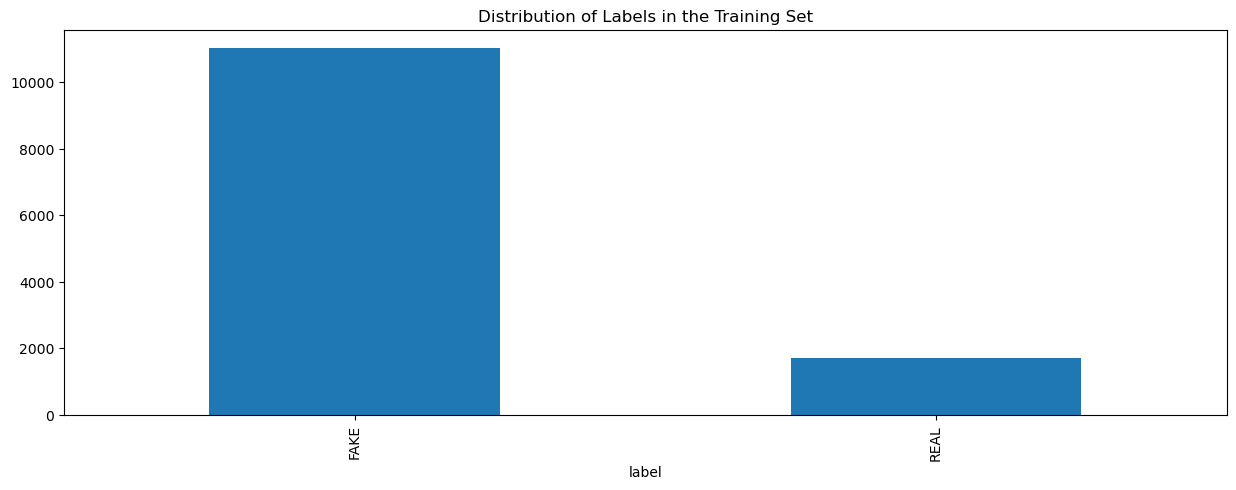

label
FAKE    11016
REAL     1722
Name: label, dtype: int64


In [7]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15,5),kind='bar',title="Distribution of Labels in the Training Set")
plt.show()
print(train_sample_metadata.groupby('label')['label'].count())

In [8]:
real_df = train_sample_metadata[train_sample_metadata["label"] == "REAL"]
fake_df = train_sample_metadata[train_sample_metadata["label"] == "FAKE"]
# sample_size = 1722

real_df = real_df.sample(1722, random_state=42)
fake_df = fake_df.sample(1722, random_state=42)

train_sample_metadata = pd.concat([real_df, fake_df])

In [9]:
train_sample_metadata.shape

(3444, 3)

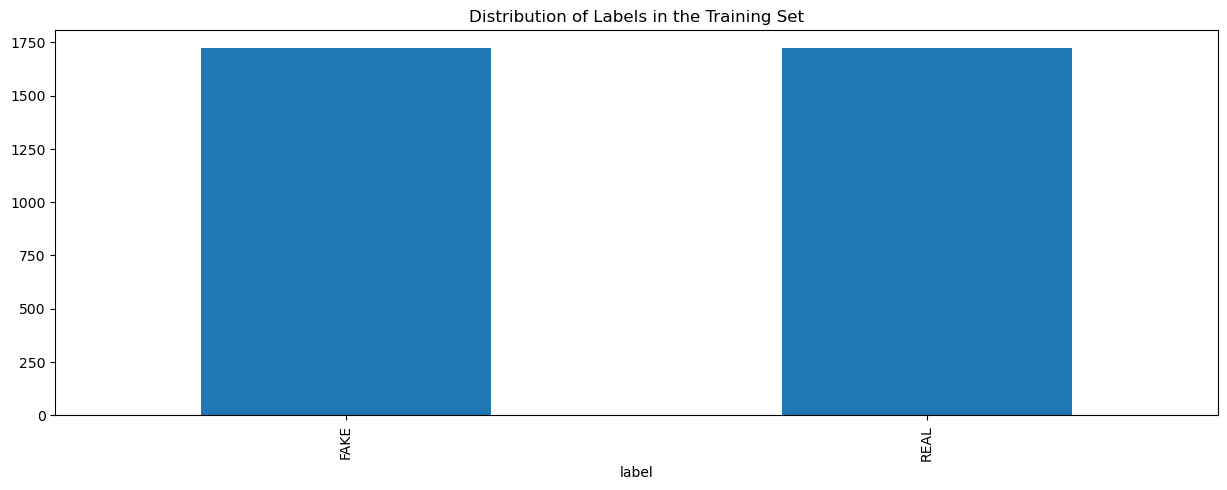

label
FAKE    1722
REAL    1722
Name: label, dtype: int64


In [10]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15,5),kind='bar',title="Distribution of Labels in the Training Set")
plt.show()
print(train_sample_metadata.groupby('label')['label'].count())

In [11]:
# pip install git+https://github.com/tensorflow/docs

In [12]:
from tensorflow_docs.vis import embed
import keras
from imutils import paths
import tensorflow as tf
import imageio
import cv2


In [13]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
        )
    except RuntimeError as e:
        print(e)

In [14]:
IMG_SIZE = 224
def crop_center_square(frame):
    y,x = frame.shape[0:2]
    min_dim = min(y,x)
    start_x = (x//2) - (min_dim//2)
    start_y = (y//2) - (min_dim//2)
    return frame[start_y: start_y + min_dim, start_x: start_x + min_dim]

def load_video(path,max_frames=0,resize=(IMG_SIZE,IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame,resize)
            frame = frame[:,:,[2,1,0]]
            frames.append(frame)
            
            if len(frames) ==max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [15]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        pooling = "avg",
        input_shape = (IMG_SIZE,IMG_SIZE,3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    
    inputs = keras.Input((IMG_SIZE,IMG_SIZE,3))
    preprocessed = preprocess_input(inputs)
    
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs,outputs,name='feature_extractor')

feature_extractor = build_feature_extractor()

In [16]:
label_processor = keras.layers.StringLookup(num_oov_indices=0,vocabulary=np.unique(train_sample_metadata.label))
print(label_processor.get_vocabulary())

['FAKE', 'REAL']


In [17]:
labels = train_sample_metadata.label.values
labels

array(['REAL', 'REAL', 'REAL', ..., 'FAKE', 'FAKE', 'FAKE'], dtype=object)

In [18]:
labels = label_processor(labels[...,None]).numpy()
labels

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [19]:
IMG_SIZE = 224
BATCH_SIZE = 10
EPOCHS = 100

MAX_SEQ_LENGTH = 200
NUM_FEATURES =2048

In [20]:
def prepare_all_videos(df,root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df['label'].values
    labels = label_processor(labels[...,None]).numpy()
    
    frame_masks= np.zeros(shape=(num_samples,MAX_SEQ_LENGTH),dtype='bool')
    frame_features = np.zeros(
        shape=(num_samples,MAX_SEQ_LENGTH,NUM_FEATURES),dtype="float32"
    )
    
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir,path))
        frames = frames[None,...]
        
        temp_frame_mask = np.zeros(shape=(1,MAX_SEQ_LENGTH,),dtype='bool')
        temp_frame_features = np.zeros(
        shape=(1,MAX_SEQ_LENGTH,NUM_FEATURES),dtype="float32"
        )
        
        for i,batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH,video_length)
            for j in range(length):
                temp_frame_features[i,j,:] = feature_extractor.predict(batch[None,j,:])
            temp_frame_mask[i,:length] =1
        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
    return (frame_features,frame_masks),labels

In [21]:
from sklearn.model_selection import train_test_split

Train_set , Test_set = train_test_split(train_sample_metadata,test_size = 0.2,random_state=42,stratify=train_sample_metadata['label'])

print(Train_set.shape,Test_set.shape)

(2755, 3) (689, 3)


In [22]:
train_data,train_labels = prepare_all_videos(Train_set,'train')
test_data,test_labels = prepare_all_videos(Test_set,'test')

In [23]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {test_data[1].shape}")
print(f"Train labels in train set: {train_labels.shape}")
print(f"Test labels in test set: {test_labels.shape}")

Frame features in train set: (2755, 200, 2048)
Frame masks in train set: (689, 200)
Train labels in train set: (2755, 1)
Test labels in test set: (689, 1)


In [24]:
print(train_data[0][1066][0][2047])
# print(train_data[1][27])
count = 0
for i in range(len(train_labels)):
    if train_labels[i]==1:
        count += 1
print("REAL Train Videos:",count)
count = 0
for i in range(len(train_labels)):
    if train_labels[i]==0:
        count += 1
print("FAKE Train Videos:",count)
count=0
for i in range(len(test_labels)):
    if test_labels[i]==1:
        count += 1
print("REAL Test Videos:",count)
count = 0
for i in range(len(test_labels)):
    if test_labels[i]==0:
        count += 1
print("FAKE Test Videos:",count)

0.0
REAL Train Videos: 1378
FAKE Train Videos: 1377
REAL Test Videos: 344
FAKE Test Videos: 345


In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    frame_feature_input = keras.Input((MAX_SEQ_LENGTH,NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,),dtype='bool')
    
    x = keras.layers.GRU(64,return_sequences=True)(frame_feature_input,mask=mask_input)
    x =keras.layers.BatchNormalization()(x)
    x = keras.layers.GRU(32,return_sequences=True)(x)
    x =keras.layers.BatchNormalization()(x)
    x = keras.layers.GRU(16)(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(8,activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(4,activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    output = keras.layers.Dense(len(class_vocab),activation='softmax')(x)
    
    rnn_model = keras.Model([frame_feature_input,mask_input],output)
    
    rnn_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return rnn_model

def run_exp():
    filepath = './hello/.weights.h5'
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,save_weights_only=True,save_best_only=True,verbose=1)
    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0],train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )
    seq_model.load_weights(filepath)
    _,accuracy = seq_model.evaluate([test_data[0],test_data[1]],test_labels)
    print(f"Test Accuracy,{round(accuracy*100,2)}%")
    return history,seq_model

_,sequential_model = run_exp()

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.4754 - loss: 0.6932
Epoch 1: val_loss improved from inf to 0.69315, saving model to ./hello/.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - accuracy: 0.4756 - loss: 0.6932 - val_accuracy: 0.5006 - val_loss: 0.6931
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4854 - loss: 0.6932
Epoch 2: val_loss did not improve from 0.69315
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step - accuracy: 0.4853 - loss: 0.6932 - val_accuracy: 0.4994 - val_loss: 0.6931
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5212 - loss: 0.6932
Epoch 3: val_loss improved from 0.69315 to 0.69315, saving model to ./hello/.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.5209 - loss: 0.6932 - val_accuracy: 0.5006 - val_loss: 0.6931
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.4881 - loss: 0.6932
Epoch 4: val_loss did not improve from 0.69315
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 3

In [ ]:
from IPython import embed
def prepare_single_video(frames):
    frames=frames[None,...]
    frame_mask = np.zeros(shape=(1,MAX_SEQ_LENGTH,),dtype='bool')
    frame_features = np.zeros(shape=(1,MAX_SEQ_LENGTH,NUM_FEATURES),dtype='float32')
    
    for i,batch in enumerate(frames):
        Video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH,Video_length)
        for j in range(length):
            frame_features[i,j,:] = feature_extractor.predict(batch[None,j,:])
        frame_mask[i,:length] =  1
    return frame_features,frame_mask

def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()
    frames = load_video(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER,path))
    frame_features , frame_mask = prepare_single_video(frames)
    probabilities= sequential_model.predict([frame_features,frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"    {class_vocab[i]}:{probabilities[i]*100:5.2f}%")
    return frames

test_video = "C:\\Users\\Sahu Suraj\\Videos\\New Project\\DeepFake Detection\\Check Data\Fake1.mp4"
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)


<>:25: SyntaxWarning: invalid escape sequence '\F'
<>:25: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Sahu Suraj\AppData\Local\Temp\ipykernel_8476\2713888675.py:25: SyntaxWarning: invalid escape sequence '\F'
  test_video = "C:\\Users\\Sahu Suraj\\Videos\\New Project\\DeepFake Detection\\Check Data\Fake1.mp4"


Test video path: C:\Users\Sahu Suraj\Videos\New Project\DeepFake Detection\Check Data\Fake1.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━

In [50]:
test_frames

array([[[[131, 136,  90],
         [201, 220, 182],
         [220, 252, 232],
         ...,
         [194, 207, 183],
         [194, 207, 184],
         [194, 207, 182]],

        [[112, 127,  74],
         [132, 151, 101],
         [213, 236, 218],
         ...,
         [194, 207, 182],
         [194, 207, 182],
         [194, 207, 180]],

        [[118, 124,  76],
         [162, 169, 127],
         [186, 203, 189],
         ...,
         [194, 207, 181],
         [195, 208, 181],
         [194, 208, 178]],

        ...,

        [[182, 213, 228],
         [186, 214, 221],
         [132, 149, 136],
         ...,
         [226, 244, 255],
         [192, 206, 229],
         [ 95, 105, 109]],

        [[183, 214, 231],
         [185, 215, 224],
         [127, 148, 129],
         ...,
         [224, 243, 255],
         [184, 205, 230],
         [ 88, 114,  91]],

        [[183, 214, 231],
         [185, 215, 224],
         [121, 142, 123],
         ...,
         [224, 243, 255],
        

In [27]:
sequential_model.save("BestModel.weights.h5")
sequential_model.save("BestModel.keras")